In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import sys
sys.path.append('../../src/')
import optimization_utils
import modeling_utils

In [2]:
device = torch.device('cuda')

In [3]:
img_path = '../../data/modeling_64/images/'
image_dict = {i : img_path + f for i, f in enumerate(os.listdir(img_path))}

In [4]:
data_transform = transforms.Compose([transforms.ToTensor()])

In [5]:
bird_dataset = modeling_utils.BirdDataset(image_dict, transform=data_transform)

In [6]:
data_loader = torch.utils.data.DataLoader(bird_dataset, batch_size=256, 
                                          num_workers=0, shuffle=True)

0.0 1.0


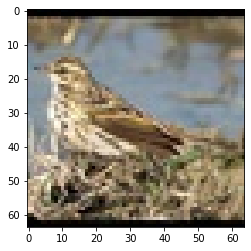

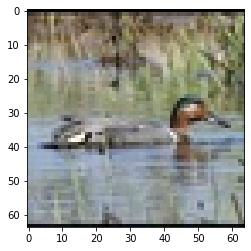

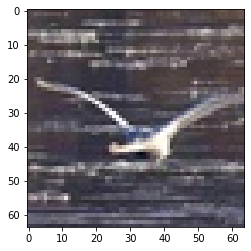

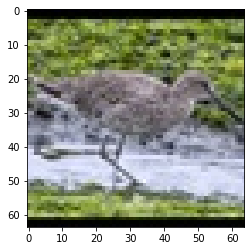

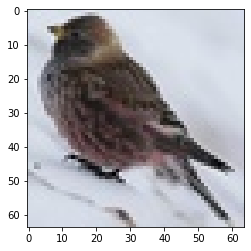

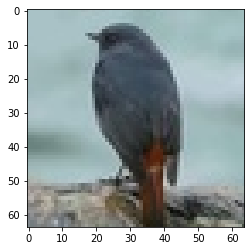

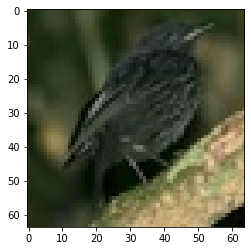

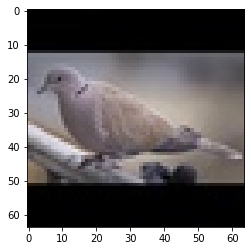

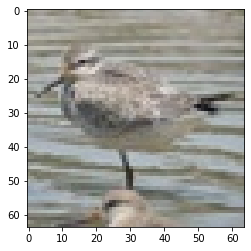

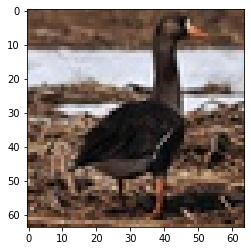

In [7]:
for batch in data_loader:
    batch = modeling_utils.swap_channels_batch(batch.data.cpu().numpy())
    print(batch.min(), batch.max())
    for i in range(10):
        plt.imshow(batch[i])
        plt.show()
    break

In [8]:
WIDTH = 64
HEIGHT = 64

## Hyperparamaters

In [9]:
NOISE_SIZE = 64
FIN_GEN_DIM = 64
INIT_DISCRIM_DIM = 64
NUM_CHANNELS = 3
IMG_DIM = 64

In [10]:
def generate_noise(size, device):
    return torch.randn(size, NOISE_SIZE, 1, 1, device=device)

In [11]:
FIXED_NOISE = modeling_utils.generate_noise(16, NOISE_SIZE, device)

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def conv_block(in_dim, out_dim, kernel_size=4, stride=2, padding=1, neg_slope=.2, activate=True):
            layers = [nn.ConvTranspose2d(in_dim, out_dim, kernel_size, stride, padding, bias=False),
                      nn.BatchNorm2d(out_dim),
            ]
            if activate:
                layers += [nn.LeakyReLU(negative_slope=neg_slope, inplace=True)]
            return layers
        
        self.main = nn.Sequential(
            *conv_block(NOISE_SIZE, FIN_GEN_DIM * 8, stride=1, padding=0),
#             *conv_block(FIN_GEN_DIM * 12, FIN_GEN_DIM * 8),
            *conv_block(FIN_GEN_DIM * 8, FIN_GEN_DIM * 4),
            *conv_block(FIN_GEN_DIM * 4, FIN_GEN_DIM * 2),
            *conv_block(FIN_GEN_DIM * 2, FIN_GEN_DIM),
            *conv_block(FIN_GEN_DIM, NUM_CHANNELS, activate=False),
            
        )
        
    def forward(self, x):
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.main(x)
        x = torch.sigmoid(x)
        return x

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def conv_block(in_dim, out_dim, kernel_size=4, stride=2, padding=1, neg_slope=.2, pool=True):
            layers = [nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding, bias=False),
                      nn.BatchNorm2d(out_dim),
                      nn.LeakyReLU(neg_slope, inplace=True)
            ]
            if pool:
                layers += [nn.AvgPool2d(2)]
            return layers
        
        self.main = nn.Sequential(
            *conv_block(NUM_CHANNELS, INIT_DISCRIM_DIM, pool=False),
            *conv_block(INIT_DISCRIM_DIM, INIT_DISCRIM_DIM*2, pool=True),
            *conv_block(INIT_DISCRIM_DIM*2, INIT_DISCRIM_DIM*4, pool=True),
#             *conv_block(INIT_DISCRIM_DIM*4, INIT_DISCRIM_DIM*8, pool=True),
        )
        self.part_2 = nn.Sequential(
            nn.Linear(1024, 1),
#             nn.LeakyReLU(negative_slope=.2, inplace=True),
#             nn.Linear(256, 1),
        )
        
    def forward(self, x):
        x = self.main(x)
        x = x.view((-1, 1024))
        x = self.part_2(x)
        return x

In [14]:
gen = Generator().to(device)
# gen.apply(weights_init)

In [15]:
gen(modeling_utils.generate_noise(16, NOISE_SIZE, device=device)).size()

torch.Size([16, 3, 64, 64])

In [16]:
discrim = Discriminator().to(device)
# discrim.apply(weights_init)

In [17]:
discrim(next(iter(data_loader)).to(device)).size()

torch.Size([256, 1])

In [18]:
gen_opt = optim.Adam(gen.parameters())
discrim_opt = optim.RMSprop(discrim.parameters(), lr = 0.0002)

In [19]:
DISCRIM_NOISE = .05

In [20]:
# real_label = 1
# fake_label = 0
# bce_loss = nn.BCEWithLogitsLoss()

In [21]:
# PLOT_ERR_CHANCE = 10**-2

In [22]:
# # this doesnt' really define an "epoch"
# # should just be the time between samples
# def train_for_epoch():
#     gen.train()
#     discrim.train()
#     pbar = tqdm_notebook(total=len(data_loader), leave=False)
#     for batch_real in data_loader:
#         batch_real = batch_real.to(device)
#         # TRAIN THE DISCRIMINATOR
#         # First on real data
#         # Sometimes files dont load because the images were bad. So recompute the batch size
#         batch_size = batch_real.size()[0]
#         discrim.zero_grad()
        
#         label = torch.full((batch_size,), real_label, device=device)
#         if DISCRIM_NOISE:
#             indexer = np.random.rand() < DISCRIM_NOISE
#             label[np.arange(batch_size)[indexer]] = fake_label
            
#         output = discrim(batch_real)
#         err_discrim_real = bce_loss(output.squeeze(), label.squeeze())
#         err_discrim_real.backward()
#         discrim_real_pred = torch.sigmoid(output).mean().item()
        
#         # now train on fake data
#         noise = modeling_utils.generate_noise(batch_size, NOISE_SIZE, device)
#         fake = gen(noise)
#         output = discrim(fake.detach())
        
#         label.fill_(fake_label)
#         if DISCRIM_NOISE:
#             indexer = np.random.rand() < DISCRIM_NOISE
#             label[np.arange(batch_size)[indexer]] = real_label
        
#         err_discrim_fake = bce_loss(output.squeeze(), label.squeeze())
#         err_discrim_fake.backward()
#         discrim_fake_pred = torch.sigmoid(output).mean().item()
#         discrim_opt.step()
        
#         # Train the generator
#         gen.zero_grad()
#         label.fill_(real_label)
#         output = discrim(fake)
#         err_gen = bce_loss(output.squeeze(), label.squeeze())
#         err_gen.backward()
#         gen_opt.step()
#         pbar.update(1)
        
#         if np.random.rand() < PLOT_ERR_CHANCE:
#             print(discrim_real_pred, discrim_fake_pred)
#     #Make sure the progress bar goes away
#     pbar.update(1000)

In [23]:
# def sample_gen_images(fixed=False, clear_occasionally = True):
#     if fixed:
#         noise = FIXED_NOISE
#     else:
#         noise = modeling_utils.generate_noise(16, NOISE_SIZE, device)
#     output = gen(noise).data.cpu().numpy()
#     output = modeling_utils.swap_channels_batch(output)
#     output = np.clip(output, 0, 1)
    
#     fig, axs = plt.subplots(4, 4)
#     fig.set_size_inches(8, 8)
#     for i in range(4):
#         for j in range(4):
#             axs[i,j].imshow(output[i*4+j])
#     plt.show()
    
    

In [24]:
# nb_epochs = 100
# pbar = tqdm_notebook(total = nb_epochs)
# for i in range(nb_epochs):
#     train_for_epoch()
#     sample_gen_images()
#     pbar.update(1)

In [25]:
# torch.save(gen.state_dict(), 'aug_gen.pt')
# torch.save(discrim.state_dict(), 'aug_discrim.pt')

In [26]:
# import importlib
# importlib.reload(optimization_utils)
# importlib.reload(modeling_utils)

In [27]:
# import importlib
# importlib.reload(optimization_utils)

In [28]:
# torch.save(gen.state_dict(), 'gen_64.pt')
# torch.save(discrim.state_dict(), 'discrim_64.pt')

In [29]:
nb_epochs = 100
for i in range(nb_epochs):
    optimization_utils.train_for_epoch_traditional(gen, gen_opt, discrim, discrim_opt, data_loader, device, NOISE_SIZE, 
        discrim_noise_level=.05, checkpoint_interval=.05, save_dir='./first_pass/', print_metrics=False, fixed_noise=FIXED_NOISE,
        plot_gen_samples=False, save_gen_samples=True, save_gen_fixed=True, tensorboard=True, fid=True, epoch_nb=i,
        fid_real_path = '../../data/modeling_64/images/')

KeyboardInterrupt: 

In [ ]:
sample_gen_images()

In [ ]:
sample_gen_images()

In [ ]:
sample_gen_images()

In [ ]:
sample_gen_images()

In [ ]:
sample_gen_images()

In [ ]:
sample_gen_images()

In [ ]:
sample_gen_images()